# **Полный файл для анализа, обработки данных.</br>Обучение модели, оптимизация параметров и метрика.**

### Импорт всех необходимых библиотек

In [172]:
import pandas as pd # Для работы с данными
import numpy as np # Для мат алгоритмов с данными
import re # Для отделения col и номера
import missingno as msn # График для проверки наполненности данных
import matplotlib.pyplot as plt # Для работы с графиками
import warnings # Игнор предупреждений, чтобы вывод выглядел +- красиво
warnings.filterwarnings("ignore")
from fancyimpute import KNN # Алгоритм для заполнения данных
from sklearn.ensemble import RandomForestClassifier # Классификационная модель
from sklearn import metrics # ROC-AUC метрики

### Загружаем исходные данные для обработки

In [173]:
train_df = pd.read_csv("train.csv")
valid_df = pd.read_csv("valid.csv")

### Анализ

In [144]:
train_df.shape

(14456, 17)

In [174]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14456 entries, 0 to 14455
Columns: 2666 entries, report_date to col2663
dtypes: float64(2316), int64(3), object(347)
memory usage: 294.0+ MB


In [152]:
types = train_df.dtypes
train_df = train_df.T.drop_duplicates().T
train_df = train_df.astype(types[train_df.columns])

In [ ]:
temp_df = train_df.loc[:, ((train_df.isnull())).mean() < 0.8]
msn.bar(temp_df, fontsize=10, color=(1, 0.75, 0.8))

Выводим в txt файлы уникальные значения каждого типа, чтобы виднее было, как объединять данные</br>
Либо загружаем датасеты в PowerBI/Excel и смотрим там значения по колонкам</br>
В результате анализа обнаружаем, что колонки с похожими значениями стоят рядом,</br>
значит колонки, значащие один параметр, заранее сгруппированы, осталось их только соединить</br>
и проанализировать результат соединения, сколько колонок соединилось и насколько увеличилась наполненность.

### Создаём функцию для одинаковой обрабокти ДатаФреймов. На основе анализа конечно.

In [175]:
def process(df, is_valid=False):
    df.dropna(how='all', axis=1, inplace=True) # Удаляем полностью пустые колонки
    df.drop_duplicates() # Избавляемся от дупликатов

    df = df.select_dtypes(exclude=['object'])
    # Удаляем все строковые колонки, так как при анализе выяснилось, что:
    # 1. В них мало данных
    # 2. Трудно обучить на них модель, так как она принимает числовые значения

    # Алгоритм для перевода всех возможных колонок в INT64, для более удобной раздельной обработки
    float_columns = df.select_dtypes(include=np.number).columns
    for col in float_columns:
        temp = df[col].fillna(0)
        if temp.apply(lambda x: x == int(x)).all():
            df[col] = df[col].astype("Int64")
    df = df.loc[:, (df != 0).any(axis=0)]

    # Разбиваем ДатаФрейм на Float и Int части
    df_float = df.select_dtypes(include=["float64"])
    df_int = df.select_dtypes(include=["int64"])
    df_int = df_int.astype(float)

    # Сносим все нежелательные данные для обработки
    df_float.replace(["nan", np.float64(0.0), np.float64(1.0)], np.nan, inplace=True)
    df_int = df_int.drop(["client_id","target"],axis=1)
    df_int.replace("nan",np.nan, inplace=True)

    # Merge колонок
    def merge_columns_with_common_values(df, temp_col):
        base_toggle = True # Свитч для правильного старта
        unique_columns = [] # Запись о пройденных колонках
        column_groups = {} # Группы для объединения

        for col in df.columns:
            if col in unique_columns: continue # Если колонка была обработана, переход к следующей

            if col != df.columns[1]: base_toggle = False # Стартовый свитч

            column_groups[col] = [col] # Инициализация группы объединённых колонок

            for next_col in df.columns: # Пробежка по следующим колонкам
                if col == next_col or next_col in unique_columns: continue

                common_values = list(set(df[col].unique()).intersection(set(df[next_col].unique()))) # Нахождение одинаковых значений между колонками
                if np.nan in common_values: common_values.remove(np.nan) # Выбрас nan из одинаковых значений

                match = re.match(r"([a-zA-Z]+)(\d{1,4})", col) # Индекс текущей колонки
                match1 = re.match(r"([a-zA-Z]+)(\d{1,4})", next_col) # Индекс следующей колонки
                def calc_jump():
                    if base_toggle:return False # Правильный старт
                    else:
                        match = re.match(r"([a-zA-Z]+)(\d{1,4})", temp_col) # Перерасчет индекса по последней колонке в группе
                        is_jump = (int(match1.group(2)) - int(match.group(2))) > 5 # Высчитываем, есть ли прыжок
                        return is_jump

                if (len(common_values) >= 1): # Если есть общие значения
                    if calc_jump(): # Высчитываем, есть ли прыжок между индексами колонок более, чем на 5
                        temp_col = next_col
                        break # Есть прыжок, закрываем группу
                    temp_col = next_col # Следующая колонка становится последней в группе
                    column_groups[col].append(next_col) # Добавление колонки в группу для объединения
                    unique_columns.append(next_col) # Добавление колонки в уникальные
                    # print(f"Merged {col} and {next_col}: common_values = {common_values}") # Тут был лишний вывод для отладки
                else:
                    if calc_jump(): # Если же не было общих значений, ищем их между последней в группе и следующей, не забываем про возможность прыжка
                        temp_col = next_col
                        break # Есть прыжок, закрываем группу
                    common_values = list(set(df[temp_col].unique()).intersection(set(df[next_col].unique())))
                    if len(common_values) >= 1:
                        temp_col = next_col
                        column_groups[col].append(next_col)
                        unique_columns.append(next_col)
                        # print(f"Merged {col} and {next_col}: common_values = {common_values}")
                    else:break # Это выполняется в случае, когда появляется уникальная колонка, группа окончена

            unique_columns.append(col) # Добавляем колонку в список уникальных

        # Цикл для Merge групп
        for group_name, group_columns in column_groups.items():
            if len(group_columns) > 1:
                df[group_name] = (df[group_columns].bfill(axis=1).iloc[:, 0])
                # print(f"Merged columns {group_columns} into {group_name}")
            else:
                df[group_name] = df[group_columns[0]]

        df = df[[col for col in df.columns if col in column_groups]]

        return df

    # Вызываем функцию, описанную выше и получаем сMerge'нные ДатаФреймы
    df_int = merge_columns_with_common_values(df_int, "col2")
    df_float = merge_columns_with_common_values(df_float, "col4")

    # Запихиваем получившееся в один датафрейм
    df_not_sorted = pd.concat([df['client_id'], df['target'], df_int, df_float],axis=1)

    # Сортируем ДатаФрейм
    order_dict = {}
    order_list = ['client_id','target']
    columns = df_not_sorted.columns
    for column in columns:
        if 'col' in column:
            order_dict[column] = int(re.match(r"([a-zA-Z]+)(\d{1,4})", column).group(2))
    sorted_columns = {k: v for k, v in sorted(order_dict.items(), key=lambda item: item[1])}
    for k in sorted_columns: order_list.append(k)
    df = df_not_sorted[order_list]

    # Наполняем данные алгоритмом kNN
    if not is_valid: df = df.drop(columns=['col2295', 'col2543', 'col2575'])
    df = df.loc[:, ((df.isnull())).mean() < 0.8] # Дропаем, где наполненность менее 20%
    # Разделяем
    df_target_0 = df[df['target'] == 0]
    df_target_1 = df[df['target'] == 1]
    # Заполняем отдельно
    df_filled_0 = pd.DataFrame(KNN(k=6).fit_transform(df_target_0), columns=df_target_0.columns)
    df_filled_1 = pd.DataFrame(KNN(k=6).fit_transform(df_target_1), columns=df_target_1.columns)
    # if not is_valid: df_filled_0 = df_filled_0.sample(n=len(df_target_1), random_state=42)
    # Соединяем
    df = pd.concat([df_filled_0, df_filled_1])

    return df


### Вызываем этот огромный пласт кода

In [176]:
train_df = process(train_df)
valid_df = process(valid_df, True)
valid_df = valid_df[train_df.columns]

Imputing row 1/14020 with 6 missing, elapsed time: 15.798
Imputing row 101/14020 with 3 missing, elapsed time: 15.812
Imputing row 201/14020 with 6 missing, elapsed time: 15.825
Imputing row 301/14020 with 3 missing, elapsed time: 15.837
Imputing row 401/14020 with 4 missing, elapsed time: 15.849
Imputing row 501/14020 with 4 missing, elapsed time: 15.860
Imputing row 601/14020 with 7 missing, elapsed time: 15.872
Imputing row 701/14020 with 7 missing, elapsed time: 15.886
Imputing row 801/14020 with 3 missing, elapsed time: 15.901
Imputing row 901/14020 with 3 missing, elapsed time: 15.916
Imputing row 1001/14020 with 3 missing, elapsed time: 15.930
Imputing row 1101/14020 with 0 missing, elapsed time: 15.943
Imputing row 1201/14020 with 3 missing, elapsed time: 15.955
Imputing row 1301/14020 with 6 missing, elapsed time: 15.967
Imputing row 1401/14020 with 3 missing, elapsed time: 15.979
Imputing row 1501/14020 with 6 missing, elapsed time: 15.991
Imputing row 1601/14020 with 4 missi

### Обучение модели и метрика ROC-AUC

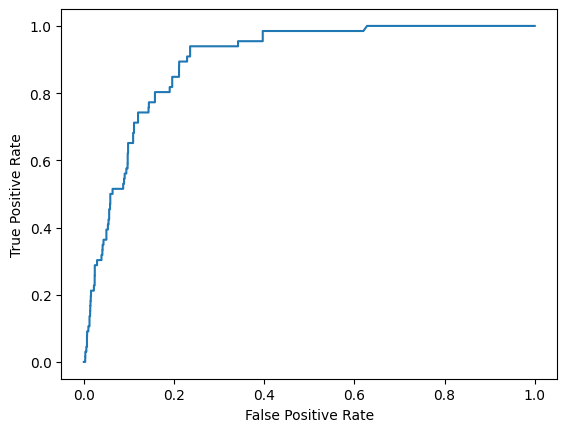

AUC: 0.897


In [177]:
# Загрузка Данных
X_train = train_df.drop(columns='target')
y_train = train_df['target']
X_test = valid_df.drop(columns='target')
y_test = valid_df['target']

# инициализация и обучение модели
rf_classifier = RandomForestClassifier(min_samples_leaf = 7, n_estimators = 35, random_state=384)
rf_classifier.fit(X_train, y_train)

# предсказание вероятностей
y_pred_proba = rf_classifier.predict_proba(X_test)[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

# построение ROC кривой
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

auc = metrics.roc_auc_score(y_test, y_pred_proba)
print("AUC: %.3f" % auc)

#### Сводка по данным
Если в train_df количество строк, где target=0, равным количеству строк, где target=1, то точность модели снизится с 0.897 до 0.835

### Подбор параметров

In [ ]:
best_auc = 0.0
best_min_samples_leaf = 0
best_n_estimators = 0

for var1 in range(1,101):
    for var2 in range(1,101):
        rf_classifier = RandomForestClassifier(min_samples_leaf = var1, n_estimators = var2, random_state=384)
        rf_classifier.fit(X_train, y_train)
        y_pred_proba = rf_classifier.predict_proba(X_test)[:,1]
        auc = metrics.roc_auc_score(y_test, y_pred_proba)
        if auc > best_auc:
            best_auc = auc
            best_min_samples_leaf = var1
            best_n_estimators = var2


print("AUC: %.3f" % best_auc, f"\nbest_min_samples_leaf = {best_min_samples_leaf}\nbest_n_estimators = {best_n_estimators}")
# AUC: 0.897
# best_min_samples_leaf = 7
# best_n_estimators = 35

AUC: 0.833 
best_min_samples_leaf = 7
best_n_estimators = 35


### Подбор параметров при помощи GridSearchCV

In [73]:
from sklearn.model_selection import GridSearchCV

# Определение модели
model = RandomForestClassifier(random_state=384)

# Определение сетки гиперпараметров
param_grid = {
    'n_estimators': range(1,36),  # Количество деревьев
    'max_depth': [None,range(1,51)],     # Максимальная глубина деревьев
    'min_samples_split': range(1,36),    # Минимальное количество образцов для разделения узла
    'min_samples_leaf': range(1,8)      # Минимальное количество образцов в листе
}

# Создание объекта GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)

# Обучение модели с перебором гиперпараметров
grid_search.fit(X_train, y_train)

# Вывод лучших гиперпараметров
print("Best parameters found: ", grid_search.best_params_)

# Вывод лучшей точности
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Оценка модели на тестовой выборке
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test set accuracy: {:.2f}".format(test_accuracy))

Best parameters found:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 20}
Best cross-validation score: 0.90
Test set accuracy: 0.77


#### **С соотношением target 1:1**</br>
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 7, 'min_samples_split': 17, 'n_estimators': 35}</br>
Best cross-validation score: 0.87</br>
Test set accuracy: 0.78</br>
AUC: 0.833</br>
при выставленных **min_samples_leaf = 7** и **n_estimators = 35**

Best parameters found:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 20}</br>
Best cross-validation score: 0.90</br>
Test set accuracy: 0.77</br>
AUC: 0.842</br>
без предопределённых **min_samples_leaf** и **n_estimators**

Разница в auc = 0.009

#### **Без выставленного соотношения**</br>
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 31}</br>
Best cross-validation score: 0.99</br>
Test set accuracy: 0.98

## **Итог подбора параметров, самые оптимальные:**

max_depth = None, min_samples_leaf = 7, min_samples_split = 18, n_estimators = 35</br>
Best cross-validation score: 0.98</br>
Test set accuracy: 0.98

Хоть и на кросс-валидации они выдают на 0.01 меньше, но на метрике влияют на целых 0.075</br>
AUC: 0.822 против AUC: 0.897
